# Computer Vision

## Project: Image Captioning

---

In this notebook, we will use our trained model to generate captions for images in the test dataset.


Feel free to use the links below to navigate the notebook:
- [Step 1](#step1): Get Data Loader for Test Dataset 
- [Step 2](#step2): Load Trained Models
- [Step 3](#step3): Finish the Sampler
- [Step 4](#step4): Clean up Captions
- [Step 5](#step5): Generate Predictions!

<a id='step1'></a>
## Step 1: Get Data Loader for Test Dataset

Define the transform in `transform_test` that we will use to pre-process the test images.  

Note: The transform defined here agrees with the transform that we used to pre-process the training images (in **2_Training.ipynb**). 

In [15]:
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms

# Define a transform to pre-process the testing images.
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Create the data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!


Visualize an example test image, before pre-processing is applied.

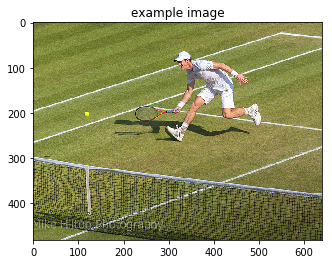

In [16]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

<a id='step2'></a>
## Step 2: Load Trained Models

In the next code cell we define a `device` that we will use move PyTorch tensors to GPU (if CUDA is available).

In [17]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### Task #1

In the next code cell, we will load the trained encoder and decoder from the previous notebook (**2_Training.ipynb**).  

### Task #2

Plug in both the embedding size and the size of the hidden layer of the decoder corresponding to the selected pickle file in `decoder_file`.

In [18]:
# Watch for any changes in model.py, and re-load it automatically.
% load_ext autoreload
% autoreload 2

import os
import torch
from model import EncoderCNN, DecoderRNN

# Specify the saved models to load.
encoder_file = "encoder-3.pkl"
decoder_file = "decoder-3.pkl"

# Select appropriate values for the Python variables below.
embed_size = 256
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


DecoderRNN(
  (word_embeddings): Embedding(9955, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=9955, bias=True)
)

<a id='step3'></a>
## Step 3: Finish the Sampler

The code cell below need to use `sample` method in the `DecoderRNN` class in **model.py**.  This method accepts as input a PyTorch tensor `features` containing the embedded input features corresponding to a single image.

It returns as output a Python list `output`, indicating the predicted sentence.  `output[i]` is a nonnegative integer that identifies the predicted `i`-th token in the sentence.  The correspondence between integers and tokens can be explored by examining either `data_loader.dataset.vocab.word2idx` (or `data_loader.dataset.vocab.idx2word`).

In [19]:
# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# Obtain the embedded image features.
features = encoder(image).unsqueeze(1)

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

example output: [0, 3, 169, 130, 355, 1492, 39, 3, 763, 18, 1]


<a id='step4'></a>
## Step 4: Clean up the Captions

In the code cell below, we implement the `clean_sentence` function.  It takes a list of integers (corresponding to the variable `output` in **Step 3**) as input and return the corresponding predicted sentence (as a single Python string). 

In [20]:
def clean_sentence(output):
    output = output[1:-1] # take out of start and end symbol.
    words = [data_loader.dataset.vocab.idx2word[index] for index in output]
    sentence = " ".join(words)
    return sentence

In [21]:
sentence = clean_sentence(output)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

example sentence: a man is playing tennis on a court .


<a id='step5'></a>
## Step 5: Generate Predictions!

In the code cell below, we have a function (`get_prediction`) that we can use to loop over images in the test dataset and print our model's predicted caption.

In [22]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

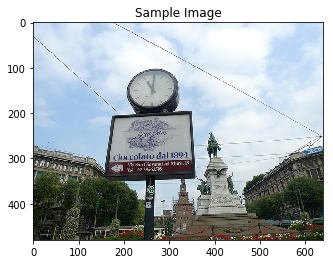

a clock on a pole in front of a building .


In [49]:
get_prediction()

As the last task in this project, we will loop over the images until we find four image-caption pairs of interest:
- Two include image-caption pairs that show instances when the model performed well.
- Two highlight image-caption pairs that highlight instances where the model did not perform well.

### The model performed well!

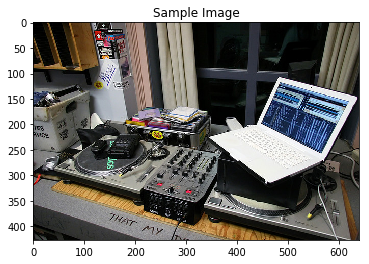

a laptop computer is sitting on a desk .


In [29]:
get_prediction()

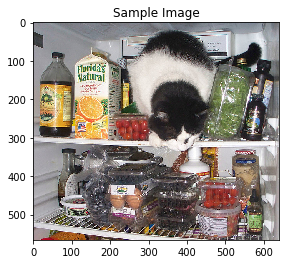

a refrigerator with a lot of food on it


In [33]:
get_prediction()

### The model could have performed better ...

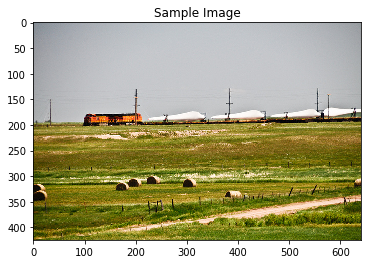

a large field with a large clock tower in the middle of the field .


In [40]:
get_prediction()

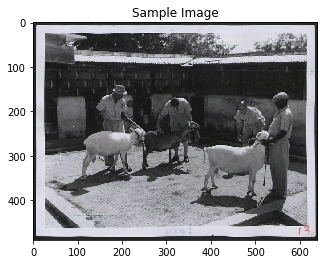

a man and a woman are standing in front of a cow .


In [44]:
get_prediction()